## Introduction

The 2020 [point-in-time count](https://www.kingcounty.gov/elected/executive/constantine/news/release/2020/July/01-homeless-count.aspx) of people experiencing homelessness for Seattle/King County was 11,751. This represents a 5% increase over the 2019 count and reflects similar trend across many counties in the western U.S.. A step towards addressing homelessness is improving our understanding of the relationship between local housing market factors and homelessness. 

The U.S. Department of Housing and Urban Development (HUD) produced a report in 2019 [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) that describes a model-based approach to understanding of the relationship between local housing market factors and homelessness. Our project is motivated by the goals of the HUD study:

"To continue progressing toward the goals of ending and preventing homelessness, we must further our knowledge of the basic community-level determinants of homelessness. The primary objectives of this study are to (1) identify market factors that have established effects on homelessness, (2) construct and evaluate empirical models of community-level homelessness.."

We will investigate whether there are alternative modeling approaches that outperform the models described in the HUD report.

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Import additional libraries
from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import RobustScaler

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

#Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from scipy.stats import uniform, randint

#Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import statsmodels.api as sm

#Missing data
import missingno as msno

from scipy.stats import uniform, randint
import xgboost as xgb

# Model metrics and analysis
from sklearn.metrics import  mean_squared_error, mean_absolute_error

# plot tree model
import graphviz

#interactions
from patsy import dmatrices

## The Data & Prep

The [data](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/05b_analysis_file_update.csv) for this project are described in HUD's report [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) in the section titled DATA.

I will refer you to this section of the HUD report for a detailed description of the sources of the data and how they were processed.

The data dictionary [HUD TO3 - 05b Analysis File - Data Dictionary.csv](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv) contains descriptions of all variables in the data set.




To prepare the raw data for analysis, the following steps were taken:

explored the raw data (general shape, columns, etc) <br>
selected relevent subsets of the data <br>
renamed columns <br>
removed missing data <br>
derived new, relevant variables as new columns <br>

## Import the Additional Question Data

In [3]:
# Additional Question
addq_df = pd.read_csv('https://raw.githubusercontent.com/cmdenault/Homelessness/main/cleanData/homelessness_clean_addq.csv')

In [4]:
addq_df.columns

Index(['year', 'coc_number', 'total_homeless', 'total_sheltered',
       'total_unsheltered', 'total_population', 'house_price_index_2009',
       'log_median_rent', 'utility_costs',
       'percentage_owners_cost_burden_2016',
       'percentage_renters_severe_cost_burden_2016', 'share_renters_2016',
       'rental_vacancy_rate', 'high_housing_density', 'number_eviction',
       'share_overcrowded_units_2016', 'city_or_urban', 'suburban',
       'rate_unemployment', 'gini_coefficient_2016', 'poverty_rate',
       'share_HUD_units', 'HUD_unit_occupancy_rate', 'share_built_before_1940',
       'total_black', 'total_latino_hispanic', 'total_asian',
       'total_pacific_islander', 'total_population_0_19',
       'total_population_65_plus', 'total_female_population', 'net_migration',
       'migration_4_year_change', 'proportion_one_person_households',
       'share_under_18_with_single_parent', 'share_veteran_status',
       'share_no_bachelors', 'medicare_reimbursements_per_enrollee',
 

In [5]:
addq_df['census_region'].head()

0    4
1    4
2    3
3    3
4    3
Name: census_region, dtype: int64

In [6]:
type(addq_df)

pandas.core.frame.DataFrame

## State your questions

The overall problem is to determine whether and how housing market factors are related to homelessness. To answer this general problem, specific questions about the data can guide our analysis.


- Do we need to scale our data in any way?
- Will making interactions between variables and our census region improve the model?
- How will we compensate for getting varying models each time using the Lasso, Ridge, and XG Boost regression (Cross validation)

## Make interactions

The predictor names of the variables we want our census region variable to interact with. For example, census_region is not present as we do not need it to interact with itself

In [7]:

predictor_names = ['house_price_index_2009',
       'log_median_rent', 'utility_costs',
       'percentage_owners_cost_burden_2016',
       'percentage_renters_severe_cost_burden_2016', 'share_renters_2016',
       'rental_vacancy_rate', 'high_housing_density', 'number_eviction',
       'share_overcrowded_units_2016', 'city_or_urban', 'suburban',
       'rate_unemployment', 'gini_coefficient_2016', 'poverty_rate',
       'share_HUD_units', 'HUD_unit_occupancy_rate', 'share_built_before_1940', 'net_migration',
       'migration_4_year_change', 'proportion_one_person_households',
       'share_under_18_with_single_parent', 'share_veteran_status',
       'share_no_bachelors', 'medicare_reimbursements_per_enrollee',
       'percentage_excessive_drinking', 'average_Jan_temperature',
       'average_summer_temperature', 'total_Jan_precipitation',
       'total_annual_precipitation', 'percent_black',
       'percent_asian', 'percent_latino_hispanic', 'percent_pacific_islander',
       'percent_female', 'percent_0_19', 'percent_pop_65_plus']

# y2, X2 = dmatrices(f'hless_rate_per10k ~ ({" + ".join(predictor_names)}) * C(census_region)', data=addq_df)

This array holds the columns we want in our X3 and y3 data frames- the predictors and outcomes respectively.

In [8]:
# make new x and y for modifying the for loop in cross validation.
predictor_names3 = ['house_price_index_2009',
       'log_median_rent', 'utility_costs',
       'percentage_owners_cost_burden_2016',
       'percentage_renters_severe_cost_burden_2016', 'share_renters_2016',
       'rental_vacancy_rate', 'high_housing_density', 'number_eviction',
       'share_overcrowded_units_2016', 'city_or_urban', 'suburban',
       'rate_unemployment', 'gini_coefficient_2016', 'poverty_rate',
       'share_HUD_units', 'HUD_unit_occupancy_rate', 'share_built_before_1940', 'net_migration',
       'migration_4_year_change', 'proportion_one_person_households',
       'share_under_18_with_single_parent', 'share_veteran_status',
       'share_no_bachelors', 'medicare_reimbursements_per_enrollee',
       'percentage_excessive_drinking', 'average_Jan_temperature',
       'average_summer_temperature', 'total_Jan_precipitation',
       'total_annual_precipitation', 'percent_black',
       'percent_asian', 'percent_latino_hispanic', 'percent_pacific_islander',
       'percent_female', 'percent_0_19', 'percent_pop_65_plus', 'census_region']


Make predictors and outcome df

In [9]:
X3 = addq_df.loc[:, predictor_names3]
y3 = addq_df[['hless_rate_per10k']]

In [10]:
X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   house_price_index_2009                      374 non-null    float64
 1   log_median_rent                             374 non-null    float64
 2   utility_costs                               374 non-null    float64
 3   percentage_owners_cost_burden_2016          374 non-null    float64
 4   percentage_renters_severe_cost_burden_2016  374 non-null    float64
 5   share_renters_2016                          374 non-null    float64
 6   rental_vacancy_rate                         374 non-null    float64
 7   high_housing_density                        374 non-null    int64  
 8   number_eviction                             374 non-null    int64  
 9   share_overcrowded_units_2016                374 non-null    float64
 10  city_or_urban 

In [11]:
X3.head()

,house_price_index_2009,log_median_rent,utility_costs,percentage_owners_cost_burden_2016,percentage_renters_severe_cost_burden_2016,share_renters_2016,rental_vacancy_rate,high_housing_density,number_eviction,share_overcrowded_units_2016,...,total_Jan_precipitation,total_annual_precipitation,percent_black,percent_asian,percent_latino_hispanic,percent_pacific_islander,percent_female,percent_0_19,percent_pop_65_plus,census_region
0,11.743647,2.438863,8.500000,15.334315,21.014816,39.727921,4.817212,0,0,4.117406,...,1.710000,16.500000,0.053811,0.093952,0.089967,0.024387,0.489629,0.269161,0.099140,4
1,9.042710,2.249699,14.607715,13.311670,19.364561,33.922234,7.000090,0,0,9.294898,...,1.710000,16.500000,0.019530,0.040104,0.055727,0.004593,0.467752,0.278562,0.109905,4
2,-0.852477,1.862248,19.492331,12.188416,24.962938,31.769621,8.249993,0,591,1.235925,...,6.669876,38.593376,0.331147,0.016632,0.040843,0.000311,0.521677,0.256410,0.149058,3
3,-8.507004,1.858394,18.899839,12.539132,27.231920,32.109203,19.424814,0,2260,1.712736,...,12.296666,58.519012,0.266807,0.016889,0.033816,0.000382,0.519669,0.254735,0.167126,3
4,0.751167,1.362010,18.803186,10.374694,21.588467,27.708206,7.218406,0,430,1.539988,...,5.462999,44.778618,0.090348,0.004901,0.042056,0.000471,0.513937,0.236545,0.190708,3


## Scale DataFrames

In [12]:
X3['census_region'].value_counts()

3    143
2     85
4     73
1     73
Name: census_region, dtype: int64

In [13]:
scaler = RobustScaler().fit(X3) #since we have a lot of outliers and some skewed distributions 

In [14]:
X3 = pd.DataFrame(data=scaler.transform(X3), columns=X3.columns.values, index=X3.index) #set the index to what it was originally

In [15]:
X3['census_region'].value_counts()

 0.0    143
-1.0     85
 1.0     73
-2.0     73
Name: census_region, dtype: int64

Region 3 -> 0 <br>
Region 2 -> -1 <br>
Region 4 -> 1 <br>
Region 1 -> -2 <br>

# Analysis

## All Inclusive Model

Lets make a regression model with all of the predictor variables to explore the data.

First, lets explore a pairplot of some predictors and homeless rates per 10k. We can also separate by region.

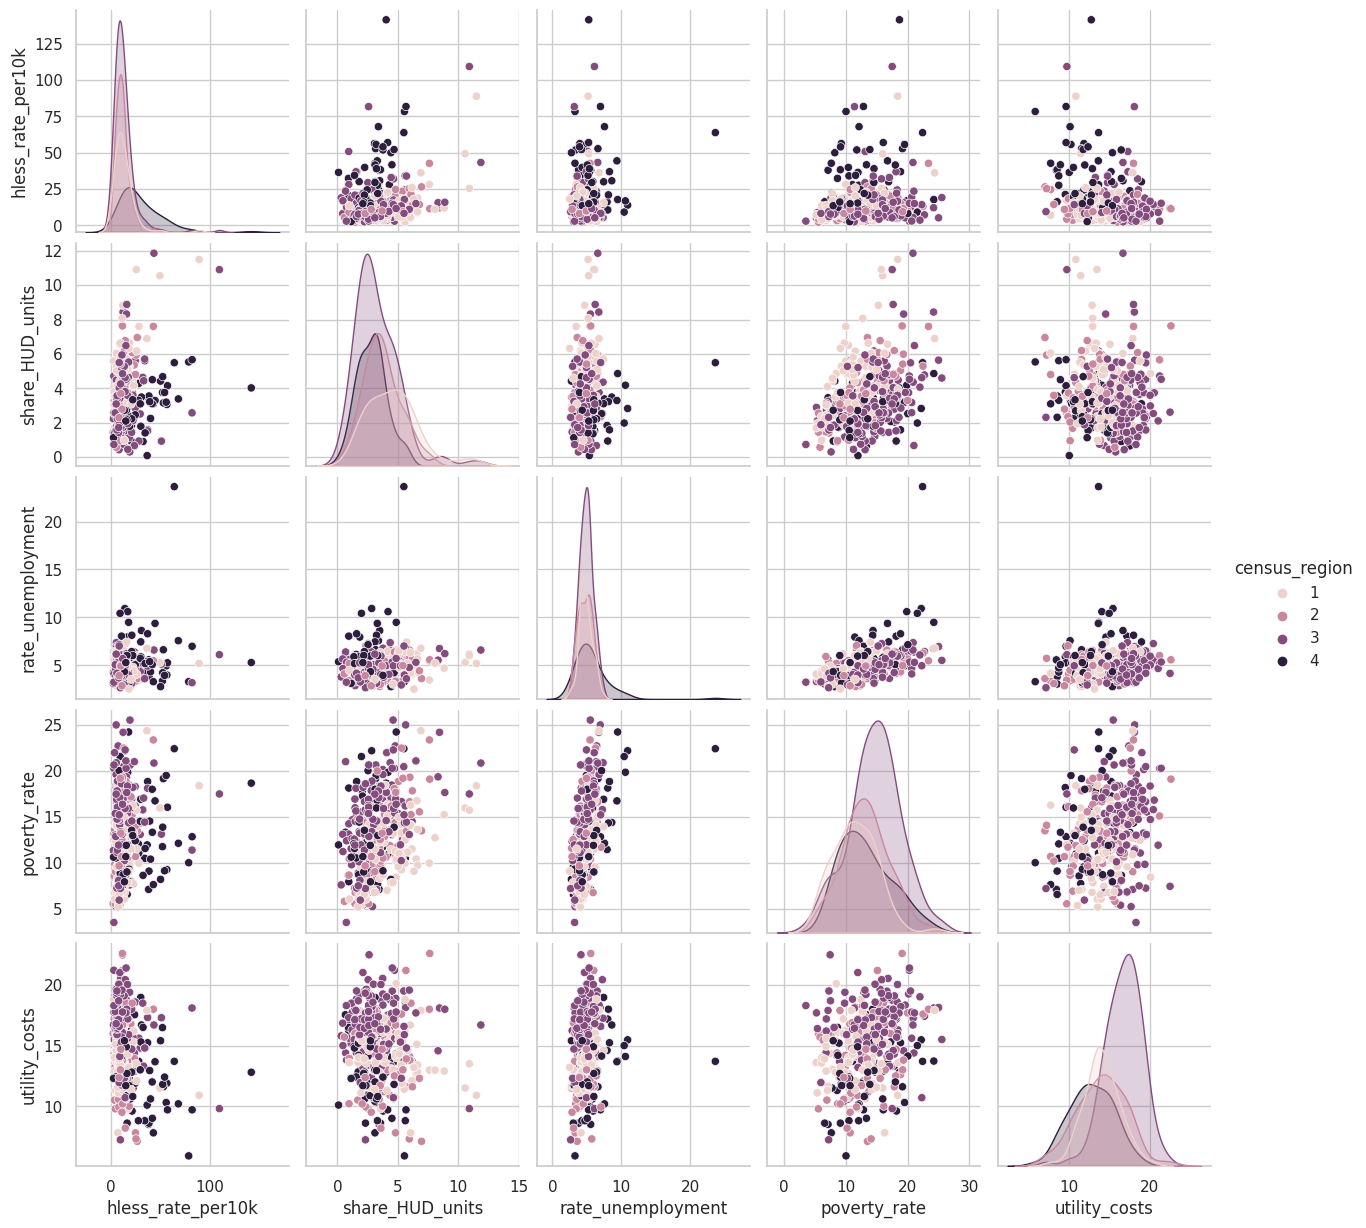

In [16]:
variables = ['hless_rate_per10k', 'share_HUD_units', 
            'rate_unemployment', 'poverty_rate', 'utility_costs', 'census_region']

sns.pairplot(addq_df[variables], hue='census_region')

Looking at the pairplots with with the homeless rate per 10k dependent variables, there doesn't seem to be any obvious realtionships. It looks like there are some outliers- cities with much higher homeless rates.

Separating by region, no obvious patterns jump out, although region 4 seems to have higher rates across the board.

Generate test and train splits for the data

In [17]:
# generate the test split
x_train, x_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=1)

In [18]:
print(x_train.shape, x_test.shape)

(299, 38) (75, 38)


In [19]:
print(y_train.shape, y_test.shape)

(299, 1) (75, 1)


##### $\rightarrow$ Generate the all inclusive model

In [20]:
model = sm.OLS(y_train, sm.add_constant(x_train)).fit()

In [21]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      hless_rate_per10k   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     11.19
Date:                Sat, 27 May 2023   Prob (F-statistic):           2.45e-36
Time:                        19:44:15   Log-Likelihood:                -1118.6
No. Observations:                 299   AIC:                             2315.
Df Residuals:                     260   BIC:                             2460.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

Many of the P values are very high, indicating that a lot of the variables are not adding much to the model. However, the high R squared indicates our model has potential. Since we have scaled variables, variables with larger coeffients indicate a stronger influence on the model.

##### $\rightarrow$ Graph and analyze

y_predict will hold the predictions when feeding the model out training data

In [22]:
y_predict = model.predict(sm.add_constant(x_train))

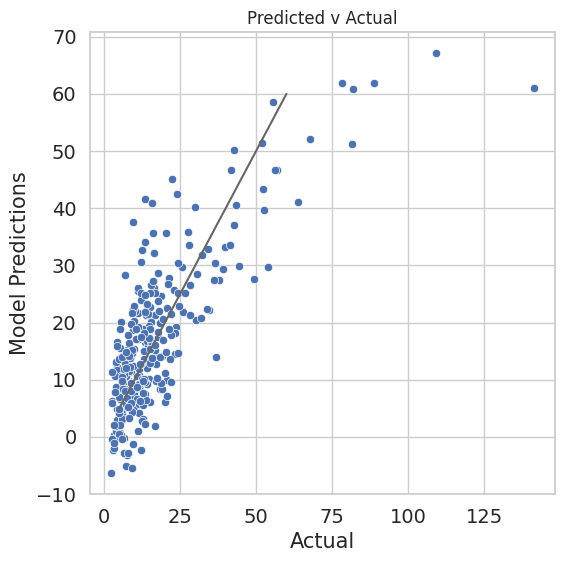

In [23]:
from pandas.compat import platform
plt.figure(figsize=(6,6))

# Add the scatter plots
sns.scatterplot(x=y_train['hless_rate_per10k'], y=y_predict) # recorded act scores

# Add an Identity Line
plt.plot([5, 60], [5, 60], c=".4")

# Customize the title
plt.title('Predicted v Actual')

# Add axis labels
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Model Predictions', fontsize=15)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

If we compare actual values of the training data to what the model predicts when given the training data, we see that the model does an okay job predicting cities on the lower end of rates of homelessness. For outlier cities with higher rates, our model underpredicts. 

Lets try the model on the unseen testing data

In [24]:
y_predict = model.predict(sm.add_constant(x_test))

In [25]:
y_predict.info()

<class 'pandas.core.series.Series'>
Int64Index: 75 entries, 67 to 82
Series name: None
Non-Null Count  Dtype  
--------------  -----  
75 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


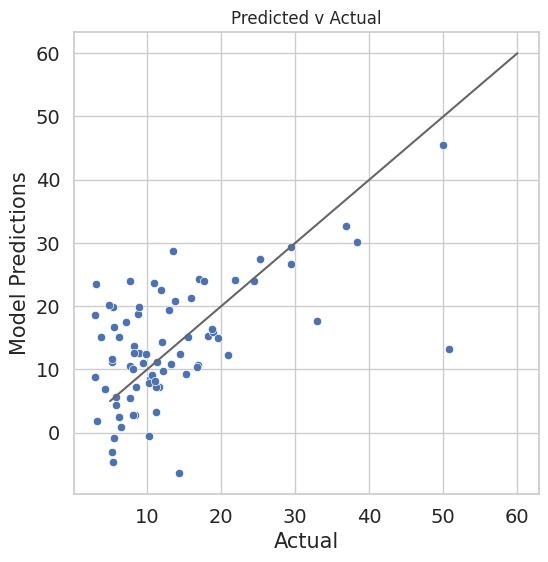

In [26]:
from pandas.compat import platform
plt.figure(figsize=(6,6))

# Add the scatter plots
sns.scatterplot(x=y_test['hless_rate_per10k'], y=y_predict) # recorded act scores

# Add an Identity Line
plt.plot([5, 60], [5, 60], c=".4")

# Customize the title
plt.title('Predicted v Actual')

# Add axis labels
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Model Predictions', fontsize=15)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

If we compare actual values of the test data to what the model predicts when given the test data, we see that the model does an okay job predicting cities on the lower end of rates of homelessness. For outlier cities with higher rates, our model underpredicts. However, even at the lower end of the homeless rates, the data points are not that close to the identity line. This model is okay, but not super accurate.

Because we have so many variables and a small amount of data in comparison, we likely overfitted. 

We have too many variables for our data set size. -> regularization, best subsets?

We have outliers. Areas with high homeless rates might be unique. -> add in other indicators to tell what we are talking about

The model might need to be non linear in some way. Our graph of actual v predicted has a curve.

##### $\rightarrow$ Use the model to compute the MSE, RMSE, and $R^2$.

In [27]:
MSE = mean_squared_error(y_test['hless_rate_per10k'], y_predict)
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test['hless_rate_per10k'], y_predict)

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 79.674  RMSE = 8.926  R-squared = 0.174


For Mean Squared Error and Root Mean Squared Error, a lower value indicates better model performance, as it means the model's predictions are closer to the actual values.

R-squared measures the goodness of fit of the model. It ranges from 0-1 and quantifies the percentage of the dependent variable's variance that can be explained by the independent variables. The closer R-squared is to 1, the better the model fits the data.

Looking at out MSE and RMSE, the values are not super low. We will compare this to other models we build shortly. 

Looking at our R squared, it is pretty low. Our model did not fit the data well. 

## Lasso Prep Work

##### $\rightarrow$ do coefficeints and stuff for the models... just to see 

In [28]:
alphas = 10**np.linspace(-4,0,10)

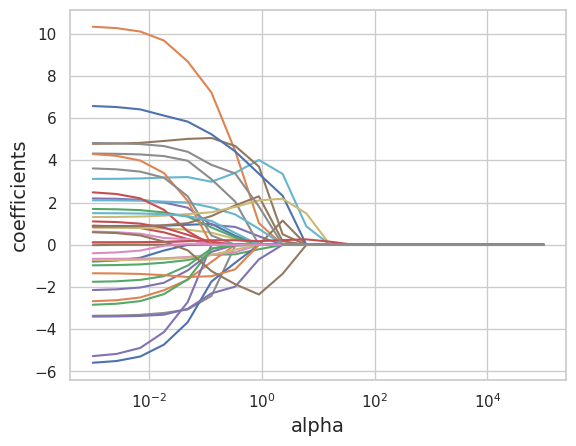

In [39]:
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

what happens to coefficients of the model as alpha gets bigger? Number of coefficients goes to 0.

## Ridge Prep Work

Ridge regression finds the parameters in the linear model by minimizing a penalized ***squared*** error:

$$C(\boldsymbol{\beta}) = \sum_{i=1}^n(y_i - \beta_{0} - \sum_{j=1}^p\beta_{j}x_{ij})^2 + \alpha \sum_{j=1}^p\beta_{j}^2 = \text{RSS} + \alpha \sum_{j=1}^p\beta_{j}^2$$

There is a hyperparameter $\alpha$ that influences the performance. We will use cross validation to determine the best value.

Create an array of possible $\alpha$ values.

In [31]:
alphas = 10**np.linspace(-3,5,20)

To understand how $\alpha$ changes the fit, note that when $\alpha$ increases, all coefficients are scaled to be smaller.

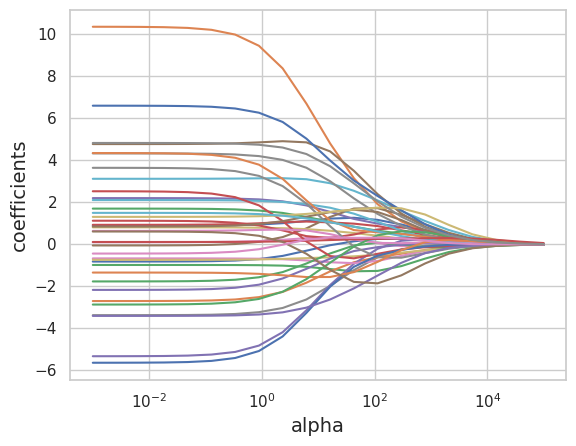

In [40]:
ridge = Ridge(max_iter=100000)
coefs1 = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(x_train, y_train.squeeze())  # Use y_train.squeeze() to convert y_train to 1D array
    coefs1.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs1))  # Use np.squeeze(coefs1) to convert coefs1 to 1D array
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize=14)
plt.ylabel('coefficients', fontsize=14)
plt.show()

These coeffients tend to get smaller. but nothing is getting set to 0, unlike the lasso

## XG Boost Prep Work

Lets look at the importance scores for a XG Boost Model with our training data. 

In [177]:
# Train your XG Boost model 
model_xgb = xgb.XGBRegressor()
model_xgb. fit(x_train, y_train)

# Retrieve feature importance scores
importance_scores = model_xgb.feature_importances_
variables = X3.columns
# Create a DataFrame to display the feature importance scores
df_importance = pd.DataFrame(data=importance_scores, index=variables, columns=['Importance Score'])
df_importance = df_importance.sort_values(by= 'Importance Score', ascending=False)
# Display the DataFrame
print (df_importance)

                                            Importance Score
census_region                                   2.529380e-01
share_renters_2016                              1.846761e-01
percent_0_19                                    7.071679e-02
share_overcrowded_units_2016                    6.912182e-02
average_summer_temperature                      4.311370e-02
percent_pop_65_plus                             4.059818e-02
proportion_one_person_households                3.640131e-02
rate_unemployment                               3.465984e-02
share_built_before_1940                         3.047637e-02
HUD_unit_occupancy_rate                         2.462969e-02
percentage_excessive_drinking                   2.174202e-02
utility_costs                                   2.006504e-02
percentage_renters_severe_cost_burden_2016      1.905423e-02
total_Jan_precipitation                         1.761004e-02
percent_female                                  1.551918e-02
share_HUD_units         

Comparitively, census region has the highest importance score, indicating that in this XG Boost model with our data without the interactions, census region has a lot of influence in the model. share_renters_2016, percent_0_19, and share_overcrowded_units_2016 are also among the most important.  

In [42]:
# Lasso
pd.DataFrame(lasso_rmse_kfold).describe()

,0
count,10.000000
mean,11.209360
std,5.124660
min,5.192478
25%,7.226700
50%,10.550015
75%,13.331389
max,20.883767


In [43]:
# Ridge
pd.DataFrame(ridge_rmse_kfold).describe()

,0
count,10.000000
mean,11.735675
std,6.041914
min,5.678664
25%,7.169732
50%,10.571307
75%,13.673361
max,24.974866


In [48]:
pd.DataFrame(reg_rmse_kfold).describe()

,0
count,10.000000
mean,12.195432
std,5.072400
min,6.022147
25%,8.139855
50%,10.982802
75%,14.637394
max,21.144391


## Making Models with Cross Validation

Make dataframes with our interactions between our census region variables and the rest of our predictor variables.

X holds the predictors, y holds the actual values for the variable we want to predict

In [50]:
y, X = dmatrices(f'hless_rate_per10k ~ ({" + ".join(predictor_names)}) * C(census_region)', data=addq_df, return_type='dataframe')

**Using K Fold validation, we will make and test Lasso, Ridge, and XG Boost Models.**

K Fold validation splits the data set into a smaller number of folds. In k-fold cross validation, we split the data set into k parts and take turns using each one of the k parts as the test set.

In [161]:
# Initialize a list to record the RMSE of each model
lasso_rmse_kfold = []
ridge_rmse_kfold = []
xgB_rmse_kfold = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the k-folds object with the number of splits
kf = KFold(n_splits=10) 

# Loop over all splits
for train_index, test_index in kf.split(X):
    x_train2 = X.iloc[train_index,:]             
    y_train2 = y.iloc[train_index] 
    y_train2 = y_train2['hless_rate_per10k'] # convert to series          

    x_test2 = X.iloc[test_index,:]               
    y_test2 = y.iloc[test_index]
    y_test2 = y_test2['hless_rate_per10k'] # convert to series

    ############ Lasso Regression ############

    # cross validation using 5 folds. let the fucntion figure out an alpha value
    lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000) 

    # fit the training data
    lassocv.fit(x_train2, y_train2)

    lasso_reg = Lasso(alpha = lassocv.alpha_).fit(x_train2, y_train2)

    # Predict
    y_prediction = lasso_reg.predict(x_test2)

    lasso_rmse_kfold.append(mean_squared_error(y_test2, y_prediction, squared=False))


    ############ Ridge Regression ############

    # cross validation using 5 folds. let the fucntion figure out an alpha value
    alphas = 10**np.linspace(-3,5,20) #########  do we need to do this in the loop???????????
    ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error') # need to put alphas. we want to minimize the squared error = 

    ridgecv.fit(x_train2, y_train2);

    # fit the training data
    ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(x_train2, y_train2) 

    # Predict
    y_predict = ridge_reg.predict(x_test2)

    ridge_rmse_kfold.append(mean_squared_error(y_test2, y_predict, squared=False))


    ############ xg boost Regression ############

    #rename columns to not contain [] AND :
    # df.columns = df.columns.str.replace('_', '')
    x_train2.columns = x_train2.columns.str.replace('[', '_')
    x_train2.columns = x_train2.columns.str.replace(']', '_')
    x_train2.columns = x_train2.columns.str.replace(':', '_')
    x_test2.columns = x_test2.columns.str.replace('[', '_')
    x_test2.columns = x_test2.columns.str.replace(']', '_')
    x_test2.columns = x_test2.columns.str.replace(':', '_')
    

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.03, 0.3), # default 0.1 
        "max_depth": randint(2, 6), # default 3
        "n_estimators": randint(100, 150), # default 100
        "subsample": uniform(0.6, 0.4)
    }

    search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, 
                                return_train_score=True, scoring = 'neg_mean_squared_error')

    search.fit(x_train2, y_train2)

    # Create an XGBoost model with the best parameters
    model_xgb = xgb.XGBRegressor(objective="reg:squarederror")

    # fit the training data
    model_xgb.fit(x_train2, y_train2)

    # Predict
    y_prediction = model_xgb.predict(x_test2)

    xgB_rmse_kfold.append(mean_squared_error(y_test2, y_prediction, squared=False))


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-161-0eafc4f15be7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_train2.columns = x_train2.columns.str.replace(']', '_')
<ipython-input-161-0eafc4f15be7>:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test2.columns = x_test2.columns.str.replace('[', '_')
<ipython-input-161-0eafc4f15be7>:63: FutureWarning: The default value of regex will change from True to F

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


##### $\rightarrow$ Analyze Aggregates

In [162]:
# Lasso
pd.DataFrame(lasso_rmse_kfold).describe()

,0
count,10.000000
mean,11.828224
std,5.829981
min,5.314270
25%,7.360361
50%,9.412220
75%,15.548574
max,22.394402


In [163]:
# Ridge
pd.DataFrame(ridge_rmse_kfold).describe()

,0
count,10.000000
mean,11.543992
std,5.733480
min,5.094277
25%,6.937700
50%,9.252757
75%,16.057191
max,21.062400


In [164]:
pd.DataFrame(xgB_rmse_kfold).describe()

,0
count,10.000000
mean,11.253302
std,5.643088
min,5.182271
25%,7.011248
50%,9.929057
75%,14.705804
max,22.933816


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Lower RMSE values indicate better predictive performance, as the model's predictions are closer to the actual values on average. Outliers can have a significant impact on the RMSE value.

It looks like the RMSE of the Lasso, XGBoost, and Ridge values are pretty similar. There are small differences, but the RMSE range from around 5 to 22 and the mean RMSE is ~11 for all of them. The ridge model is a bit lower for min, max, and mean- but not by a significant amount.

##### $\rightarrow$ Analyze Data via Bar Plot

Make the list containing root mean squared errors into a series object

In [165]:
# Lasso
lasso_rmse_kfold = pd.Series(lasso_rmse_kfold)

In [166]:
# Ridge
ridge_rmse_kfold = pd.Series(ridge_rmse_kfold)

In [167]:
# Ridge
xgB_rmse_kfold = pd.Series(xgB_rmse_kfold)

Lets make the bar plots for each model

Text(0.5, 1.0, 'Lasso Regression RMSE Values')

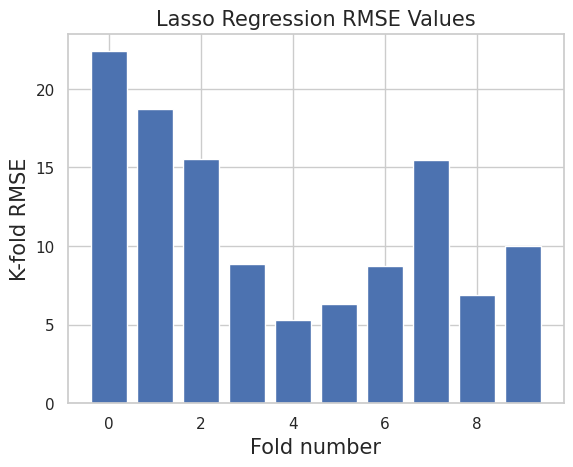

In [168]:
# Lasso
plt.bar(np.arange(kf.get_n_splits()), lasso_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);
plt.title('Lasso Regression RMSE Values', fontsize=15)


Text(0.5, 1.0, 'Ridge Regression RMSE Values')

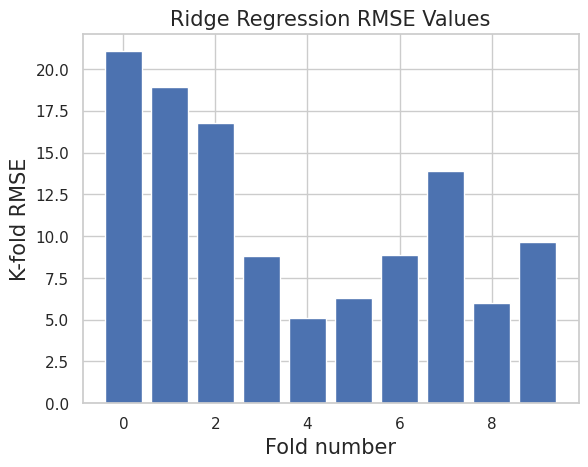

In [169]:
# Ridge
plt.bar(np.arange(kf.get_n_splits()), ridge_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);
plt.title('Ridge Regression RMSE Values', fontsize=15)

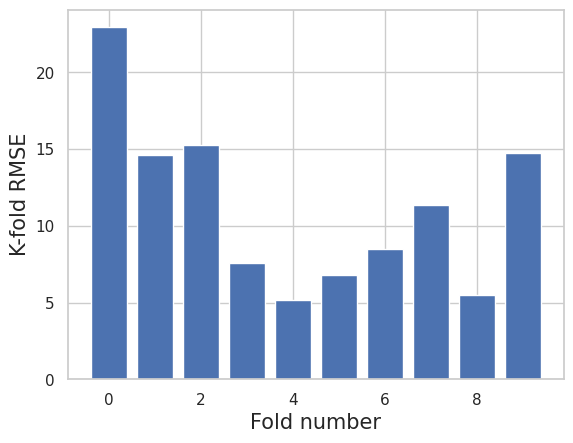

In [170]:
#plt.boxplot(tree_rmse);
plt.bar(np.arange(kf.get_n_splits()), xgB_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);

Again, it looks like the models don't have much variability. Some models have a relatively lower RMSE, only being around 5 percent points off, but other models are not too accurate being around 15-20 percent points off.

##### $\rightarrow$ Analyze Data via Histogram Plot

Text(0.5, 1.0, 'Distribution of RMSE Values Lasso Regression')

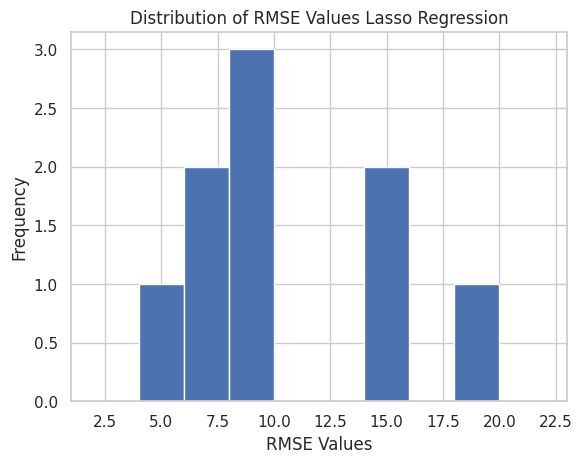

In [171]:
# Histogram
plt.hist(lasso_rmse_kfold, bins=[2,4,6,8,10,12,14,16,18,20,22]);
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE Values Lasso Regression')

Text(0.5, 1.0, 'Distribution of RMSE Values Ridge Regression')

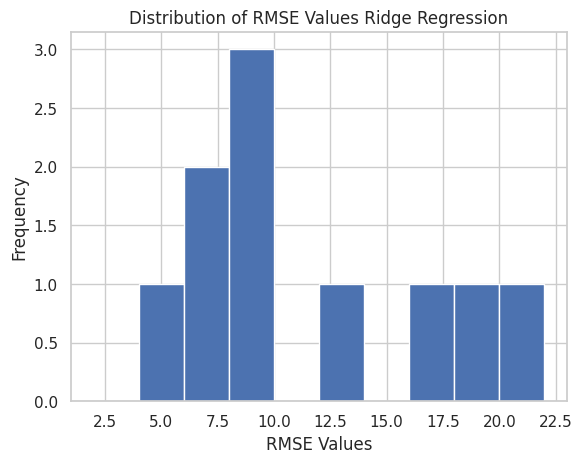

In [172]:
# Histogram
plt.hist(ridge_rmse_kfold, bins=[2,4,6,8,10,12,14,16,18,20,22]);
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE Values Ridge Regression')

Text(0.5, 1.0, 'Distribution of RMSE Values XG Boost Regression')

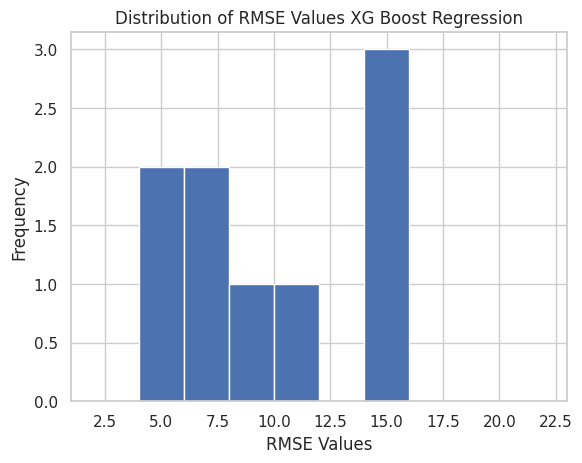

In [173]:
# XG Boost Histogram
plt.hist(xgB_rmse_kfold, bins=[2,4,6,8,10,12,14,16,18,20,22]);
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE Values XG Boost Regression')

Again, pretty similar results between lasso and ridge models. The ridge model has slightly more folds at a the higher range. The xg boost model also has about the same amounts of folds on the lower end of rmse values as the other models. 

# Conclusions

In conclusion, our Lasso, Ridge, and XG Boost Models preform similarly and have variability in their effectiveness. This is seen in our k fold cross validation, where by measuring RMSE of each fold resulted in a mean RMSE of ~11 across the three models. This means that on average, models made using the predictor variables and interactions between region and the other variables were off by an average of 11 percent points when predicting. 

However, at their best these models would only be around 5 percent points off. 

In choosing between the three models, performance is pretty similar across them.